# MD4 APC
## Estudi de projectes de KickStarter

#### Gerard Martínez Espelleta (1531236)

En aquest quadern s'ha analitzat [una base de dades](https://www.kaggle.com/kemical/kickstarter-projects) que conté informació sobre més de 300.000 projectes de Kickstarter.

L'objectiu era tant poder trobar un patró que ens indiqués com hauria de ser el nostre projecte per resultar exitós com entrenar un model que pugués classificar els projectes en exitosos o no exitosos.

D'aquesta manera si un dels nostres projectes de kickstarter és classificat com a no exitós, podem intentar no dependre totalment d'aquells diners.


Instal·lem les llibreries necessàries

In [ ]:
!pip install wordcloud
!pip install numpy==1.19.3 --user
!pip install sklearn
!pip install scipy
!pip install pandas

     |████████████████████████████████| 14.9MB 223kB/s 
ERROR: tensorflow 2.3.0 has requirement numpy<1.19.0,>=1.16.0, but you'll have numpy 1.19.3 which is incompatible.
ERROR: datascience 0.10.6 has requirement folium==0.2.1, but you'll have folium 0.8.3 which is incompatible.
ERROR: albumentations 0.1.12 has requirement imgaug<0.2.7,>=0.2.5, but you'll have imgaug 0.2.9 which is incompatible.
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.


Fem els includes necessaris

In [1]:

import numpy as np
import pandas as pd
from sklearn.impute import SimpleImputer
from sklearn import preprocessing, svm, preprocessing
from matplotlib import pyplot as plt
import scipy.stats
from sklearn.model_selection import train_test_split, cross_val_score, RandomizedSearchCV
from wordcloud import WordCloud, STOPWORDS 
from datetime import date, datetime
from collections import Counter
import copy as cp
from sklearn.ensemble import BaggingClassifier, AdaBoostClassifier, RandomForestClassifier
import time as time
import sys
from sklearn.neural_network import MLPClassifier
from sklearn.utils import shuffle
from sklearn.metrics import precision_recall_curve, confusion_matrix, plot_confusion_matrix, plot_precision_recall_curve, f1_score, accuracy_score
from sklearn.svm import SVC
from sklearn.cluster import KMeans
from sklearn.neighbors import NearestCentroid
from sklearn.linear_model import LogisticRegression


Importem la BBDD

In [2]:
df = pd.read_csv("ks-projects-201801.csv")
print(df.shape)
df.head()

(378661, 15)


,ID,name,category,main_category,currency,deadline,goal,launched,pledged,state,backers,country,usd pledged,usd_pledged_real,usd_goal_real
0,1000002330,The Songs of Adelaide & Abullah,Poetry,Publishing,GBP,2015-10-09,1000.0,2015-08-11 12:12:28,0.0,failed,0,GB,0.0,0.0,1533.95
1,1000003930,Greeting From Earth: ZGAC Arts Capsule For ET,Narrative Film,Film & Video,USD,2017-11-01,30000.0,2017-09-02 04:43:57,2421.0,failed,15,US,100.0,2421.0,30000.00
2,1000004038,Where is Hank?,Narrative Film,Film & Video,USD,2013-02-26,45000.0,2013-01-12 00:20:50,220.0,failed,3,US,220.0,220.0,45000.00
3,1000007540,ToshiCapital Rekordz Needs Help to Complete Album,Music,Music,USD,2012-04-16,5000.0,2012-03-17 03:24:11,1.0,failed,1,US,1.0,1.0,5000.00
4,1000011046,Community Film Project: The Art of Neighborhoo...,Film & Video,Film & Video,USD,2015-08-29,19500.0,2015-07-04 08:35:03,1283.0,canceled,14,US,1283.0,1283.0,19500.00


## Anàlisi de la Base de Dades

Busquem si tenim valors null


In [3]:
df.isnull().sum()

ID                     0
name                   4
category               0
main_category          0
currency               0
deadline               0
goal                   0
launched               0
pledged                0
state                  0
backers                0
country                0
usd pledged         3797
usd_pledged_real       0
usd_goal_real          0
dtype: int64

Com veiem, tenim nulls en el usd pledged i en el name. Així doncs substituïm els valors null de name per '' i eliminem les columnes de pledged i usd_pledged ja que estàn incloses en la columna usd_pledged_real. També eliminem la columna ID ja que és informació innecessària

In [4]:
df = df.drop(['usd pledged', 'pledged', 'ID'], axis=1)
df['name'].fillna('', inplace = True) 
df.head()

,name,category,main_category,currency,deadline,goal,launched,state,backers,country,usd_pledged_real,usd_goal_real
0,The Songs of Adelaide & Abullah,Poetry,Publishing,GBP,2015-10-09,1000.0,2015-08-11 12:12:28,failed,0,GB,0.0,1533.95
1,Greeting From Earth: ZGAC Arts Capsule For ET,Narrative Film,Film & Video,USD,2017-11-01,30000.0,2017-09-02 04:43:57,failed,15,US,2421.0,30000.00
2,Where is Hank?,Narrative Film,Film & Video,USD,2013-02-26,45000.0,2013-01-12 00:20:50,failed,3,US,220.0,45000.00
3,ToshiCapital Rekordz Needs Help to Complete Album,Music,Music,USD,2012-04-16,5000.0,2012-03-17 03:24:11,failed,1,US,1.0,5000.00
4,Community Film Project: The Art of Neighborhoo...,Film & Video,Film & Video,USD,2015-08-29,19500.0,2015-07-04 08:35:03,canceled,14,US,1283.0,19500.00


Mirem els percentatges de failed i de success

In [5]:
print(df['state'].value_counts(normalize=True)*100)

failed        52.215306
successful    35.376234
canceled      10.241086
undefined      0.940683
live           0.739184
suspended      0.487507
Name: state, dtype: float64


Com podem suposar que si l'han cancel·lat és perque no han vist que la cosa anés massa bé, contarem els cancel·lats com a fallats i procedirem a treballar només amb dos conjunts: 
* Fallats
* Exitosos 

ja que els altres representen un valor mes petit del 2,2% del total de dades.

A continuació podem veure la representació d'aquestes dades en format gràfic:

(370454, 12)


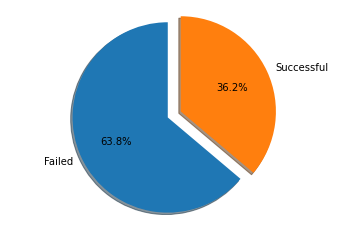

In [6]:
df['state'] = df['state'].replace('canceled', 'failed')
df = df[df['state'] != 'live']
df = df[df['state'] != 'undefined']
df = df[df['state'] != 'suspended']
aux = df['state'].value_counts(normalize=True)*100

# Pie chart, where the slices will be ordered and plotted counter-clockwise:
labels = 'Failed', 'Successful'
sizes = aux
explode = (0, 0.15)  # only "explode" the 2nd slice (i.e. 'Hogs')

fig1, ax1 = plt.subplots()
ax1.pie(sizes, explode=explode, labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=90)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
print(df.shape)
plt.show()

A continuació procedirem a analitzar la relació que existeix entre la categoría en la que etiquetem el nostre projecte i l'èxit o fracàs d'aquest.

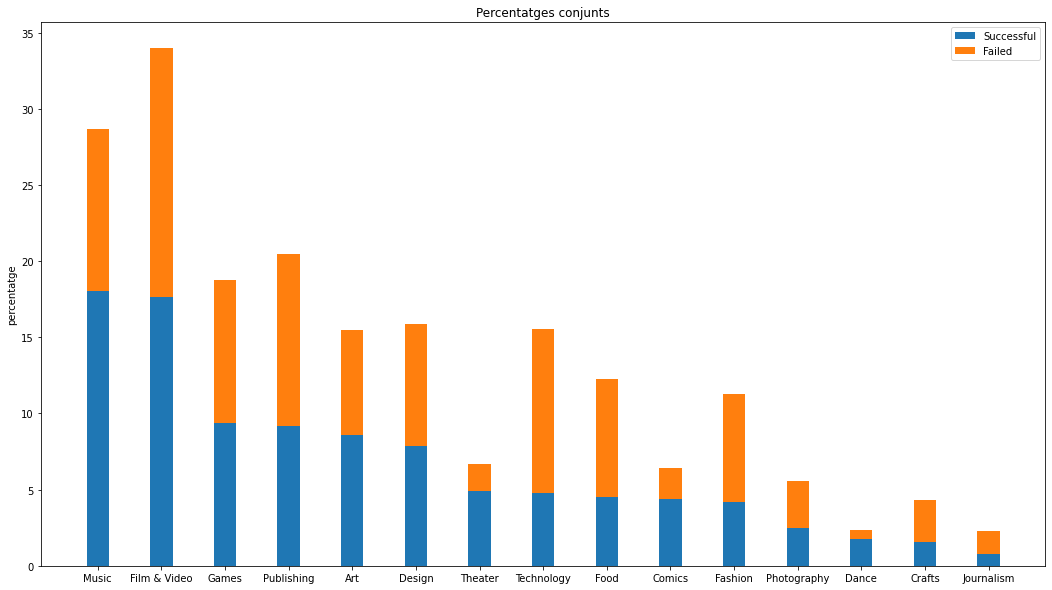

In [7]:
dftrue = df[df['state'] == 'successful']
dffalse = df[df['state'] == 'failed']

catTotal = (dftrue['main_category'].value_counts()*100)
catTrue = (dftrue['main_category'].value_counts(normalize=True)*100)
catFalse = (dffalse['main_category'].value_counts(normalize=True)*100)

labels = catTotal.index

si= []
for el in catTotal.index:
    si.append(catTrue[el])
men_means = si
si= []
for el in catTotal.index:
    si.append(catFalse[el])
women_means = si

width = 0.35       # the width of the bars: can also be len(x) sequence

fig, ax = plt.subplots(figsize=(18,10))

ax.bar(labels, men_means, width, label='Successful')
ax.bar(labels, women_means, width, bottom=men_means,
       label='Failed')

ax.set_ylabel('percentatge')
ax.set_title('Percentatges conjunts')
ax.legend()

plt.show()

En el gràfic superior podem observar totes les categories principals ordenades de més a menys percentatge d'èxit. En la figura podem observar com tot i que la categoría 'Film & Video' tingui un percentatge més alt de projectes que 'Music', aquesta última té un percentatge més elevat de projectes exitosos.

També podem observar com la categoría amb millor relació èxit-fracàs és 'Theater'.

A continuació mirarem el percentatge de projectes que provenen de cada país

In [8]:
print(df['country'].value_counts(normalize=True)*100)

US      78.193514
GB       8.966025
CA       3.916276
AU       2.073402
DE       1.095143
FR       0.775535
NL       0.757719
IT       0.749081
ES       0.594946
SE       0.463755
MX       0.440541
NZ       0.384663
DK       0.292344
IE       0.214062
CH       0.198675
NO       0.187338
BE       0.161154
AT       0.155485
HK       0.152246
SG       0.140638
N,0"     0.062626
LU       0.016466
JP       0.008368
Name: country, dtype: float64


Com podem veure, la majoria de projectes provenen d'Estats Units

Degut a la possible relació entre el mes de llançament i si els projectes son exitosos o no (p.ex si un projecte d'un videojoc es llança en una època ón també hi ha altres llançaments, pot atreure mes persones), hem procedit a mirar el percentatge de projectes exitosos i fallats llançats en cada un dels mesos de l'any.

In [9]:
mt = []
mf = []

for el in dftrue['launched']:
    d1 = date.fromisoformat(el[:10])
    mt.append(d1.month)

for el in dffalse['launched']:
    d1 = date.fromisoformat(el[:10])
    mf.append(d1.month)


catTrue = (pd.DataFrame(mt).value_counts(normalize=True)*100)
catFalse = (pd.DataFrame(mf).value_counts(normalize=True)*100)


print(catTrue)

3     9.593449
10    9.219445
4     9.027591
5     9.004449
6     8.788707
11    8.786467
7     8.720027
9     8.384096
2     8.213891
8     8.077279
1     7.076951
12    5.107647
dtype: float64


Com podem veure, el mes on millors resultats s'obtenen és al març mentres que el mes on menys èxits s'obtenen és el desembre

In [10]:
print(catFalse)

7     10.251249
8      8.885487
10     8.739186
3      8.700285
6      8.656733
5      8.656310
11     8.494364
4      8.349331
9      8.192881
2      7.698162
1      7.494778
12     5.881234
dtype: float64


En la taula superior hem pogut observar com el pitjor mes per llançar un projecte a kickstarter és el juliol, ja que més d'un 10% dels projectes pujats durant aquell més, han resultat fallats. 

De la mateixa manera, podem veure com fixant-nos només en el número de projectes fallats, el millor mes per treure un projecte seria el desembre.

Un cop obtinguts aquests resultats vam procedir a analitzar la relació entre el mes de finalització d'un projecte i l'exit o fracàs d'aquest.

Aquest anàlisi el vam fer davant de la hipòtesi de que si un projecte acaba cap als volts de nadal, és a dir, que el llançament del producte final sigui per nadal, és mes fàcil que tingui èxit.

In [11]:
mt = []
mf = []

for el in dftrue['deadline']:
    d1 = date.fromisoformat(el[:10])
    mt.append(d1.month)
for el in dffalse['deadline']:
    d1 = date.fromisoformat(el[:10])
    mf.append(d1.month)

catTrue = (pd.DataFrame(mt).value_counts(normalize=True)*100)
catFalse = (pd.DataFrame(mf).value_counts(normalize=True)*100)

print(catTrue)

5     9.409060
4     9.214966
3     9.060438
7     9.035056
8     8.927558
11    8.809609
12    8.808116
6     8.742423
10    8.560274
9     7.876467
2     6.239362
1     5.316671
dtype: float64


En la taula superior podem observar que contràriament a la hipòtesi realitzada, la majoria de projectes exitosos contemplats a la nostra base de dades, van tenir com a mes de finalització el mes de maig, mentres que el desembre es troba a la meitat de la taula.

In [12]:
print(catFalse)

8     10.109176
7      8.975129
12     8.836438
9      8.786544
5      8.757791
10     8.491827
6      8.441932
3      8.384003
11     8.338337
4      8.334109
2      6.440646
1      6.104069
dtype: float64


En aquest cas podem observar com la majoria de projectes fallats tenen com a data de finalització el mes d'agost.

A continuació, vam procedir a analitzar la part que consideràvem més important a l'hora de decidir si un projecte sería o no exitós, és a dir, el nom.

Per fer-ho vam fer un WordCloud, en aquest tipus de gràfic, les paraules es mostren més grans com mes comunes siguin, d'aquesta manera podem descobrir quines paraules es repeteixen més en els projectes exitosos i en els que no ho son.

In [13]:
def printWordCloud(words):
    stopwords = set(STOPWORDS)
    comment_words = '' 

    for el in words:
        el = str(el)
        tokens = el.split()

        for i in range(len(tokens)): 
            tokens[i] = tokens[i].lower()

        comment_words += " ".join(tokens)+" "

    wordcloud = WordCloud(width = 800, height = 800, 
                    background_color ='white', 
                    stopwords = stopwords, 
                    min_font_size = 10).generate(comment_words)

    
    # plot the WordCloud image                        
    plt.figure(figsize = (8, 8), facecolor = None) 
    plt.imshow(wordcloud) 
    plt.axis("off") 
    plt.tight_layout(pad = 0) 

    plt.show()

En la següent imatge podem veure les paraules més repetides en els projectes que resulten ser exitosos:

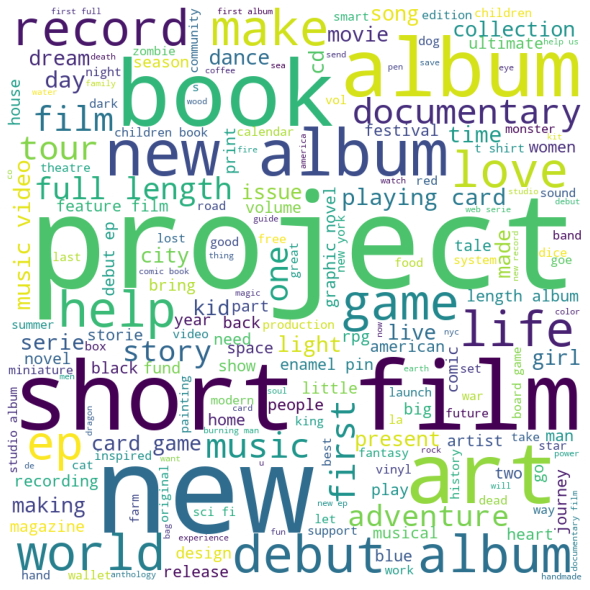

In [14]:
 printWordCloud(dftrue['name'])

En la següent figura podem veure les paraules mes repetides en els projectes que esdevenen fallats.

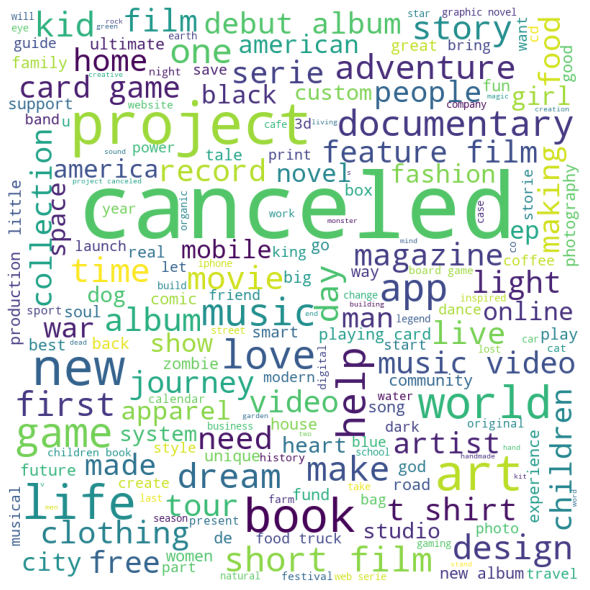

In [15]:
 printWordCloud(dffalse['name'])

## Preprocessat de les dades

Començem creant un nou dataFrame on anirem guardant totes les variables que utilitzarem posteriorment per fer la classificació

In [16]:
nd = pd.DataFrame()

Agafem les 500 paraules que mes es repeteixen en els projectes exitosos i que no estan en els projectes fallats. Per cada projecte mirarem quantes paraules del seu nom són paraules d'aquesta llista a fi d'intentar realitzar una millor classificació.

In [17]:
wordsTrue = Counter(" ".join(dftrue["name"]).split()).most_common(500)
wordsFalse = Counter(" ".join(dffalse["name"]).split()).most_common(500)

aux = []
for el in wordsTrue:
    aux.append(el[0])
wordsTrue = cp.deepcopy(aux)

aux = []
for el in wordsFalse:
    aux.append(el[0])
wordsFalse = cp.deepcopy(aux)

bestWords = [x for x in wordsTrue if x not in wordsFalse]
#print(bestWords)

answ = []


for el in df['name']:
    num = 0
    for l in el.split():
        if l in bestWords:
            num += 1
    answ.append(num)

#print(answ)
nd['common'] = np.array(answ)

Seguidament contarem el número de signes d'exclamació, signes d'interrogació, majúscules, dos punts i número de paraules de cada un dels títols dels projectes amb la intenció de comprovar si existeix algun tipus de relació entre l'èxit del projecte i aquests.

In [18]:
l = []
ex = []
qu = []
tp = []
m = []

for el in df['name']:
    l.append(len(str(el)))
    ex.append(str(el).count('!'))
    qu.append(str(el).count('?'))
    tp.append(str(el).count(':'))
    m.append(sum(1 for c in str(el) if c.isupper()))

nd['nameLen'] = np.array(l)
nd['exclamationN'] = np.array(ex)
nd['questionN'] = np.array(qu)
nd['twopointsN'] = np.array(tp)
nd['UpperCaseN'] = np.array(m)

També mirarem el temps que te cada projecte per ser dut a terme, és a dir els dies entre la seva data de llançament i la seva data de finalització.

In [19]:
def days_between(d1, d2):
    d1 = datetime.strptime(d1, "%Y-%m-%d")
    d2 = datetime.strptime(d2, "%Y-%m-%d")
    return abs((d2 - d1).days)


In [20]:
t = []
daysl = []
daysd = []
for el in df['launched']:
    daysl.append(el[:10])

for el in df['deadline']:
    daysd.append(el)

for i in range(0,len(df['launched'])):
    t.append(days_between(daysl[i], daysd[i]))
nd['time'] = np.array(t)

Per afegir variables categòriques al nostre nou dataFrame i poder fer una classificació correcte, primer les haurem de codificar, en el següent pas codifiquem les variables categòriques que ens interessen, és a dir, la categoria (tant la categoria com la subcategoria), el país i l'estat del projecte

In [21]:
leC = preprocessing.LabelEncoder()
leMC = preprocessing.LabelEncoder()
leCn = preprocessing.LabelEncoder()
leS = preprocessing.LabelEncoder()
leC.fit(df['category'])
leMC.fit(df['main_category'])
leCn.fit(df['country'])
leS.fit(df['state'])

LabelEncoder()

In [22]:
nd['category'] = leC.transform(df['category'])
nd['main_category'] = leMC.transform(df['main_category'])
nd['country'] = leCn.transform(df['country'])

Finalment, també hem calculat els diners que li falten a cada projecte per assolir el seu objectiu i ho hem posat en una altra columna

In [23]:

g = []
#nd['pledged'] = cp.deepcopy(df['usd_pledged_real'])
for el in df['usd_goal_real']:
    g.append(el)
nd['goal'] = np.array(g)

mi = []
pl = []
for el in df['usd_pledged_real']:
    pl.append(el)

nd['pledged'] = np.array(el)

for i in range(0, nd['goal'].shape[0]):
  mi.append(int(nd['goal'][i] - nd['pledged'][i]))


nd['remain'] = np.array(mi)

nd['state'] = leS.transform(df['state'])

Finalment, procedim a fer un shuffle del nostre nou dataFrame per tal d'assegurar la independència entre les dades

In [24]:
shuffle(nd)
nd.reset_index()

,index,common,nameLen,exclamationN,questionN,twopointsN,UpperCaseN,time,category,main_category,country,goal,pledged,remain,state
0,0,1,31,0,0,0,4,59,108,12,9,1533.95,524.0,1009,0
1,1,0,45,0,0,1,12,60,93,6,22,30000.00,524.0,29476,0
2,2,0,14,0,1,0,2,45,93,6,22,45000.00,524.0,44476,0
3,3,0,49,0,0,0,7,30,90,10,22,5000.00,524.0,4476,0
4,4,0,58,0,0,1,7,56,55,6,22,19500.00,524.0,18976,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
370449,370449,0,49,0,0,0,6,30,39,6,22,50000.00,524.0,49476,0
370450,370450,0,9,0,0,0,2,27,93,6,22,1500.00,524.0,976,0
370451,370451,0,71,2,0,0,5,46,93,6,22,15000.00,524.0,14476,0
370452,370452,0,24,0,0,0,4,31,138,13,22,15000.00,524.0,14476,0


In [25]:
print(nd.shape)
nd.head()

(370454, 14)


,common,nameLen,exclamationN,questionN,twopointsN,UpperCaseN,time,category,main_category,country,goal,pledged,remain,state
0,1,31,0,0,0,4,59,108,12,9,1533.95,524.0,1009,0
1,0,45,0,0,1,12,60,93,6,22,30000.00,524.0,29476,0
2,0,14,0,1,0,2,45,93,6,22,45000.00,524.0,44476,0
3,0,49,0,0,0,7,30,90,10,22,5000.00,524.0,4476,0
4,0,58,0,0,1,7,56,55,6,22,19500.00,524.0,18976,0


A continuació visualitzarem de manera gràfica la distribució de projectes exitosos i no exitosos segons les variables anteriors

In [26]:
def TrueFalsePlot(column, xName, yName, title):
    ndt = nd[nd['state'] == 1]
    ndf = nd[nd['state'] == 0]

    ctrue = (ndt[column].value_counts(normalize=True)*100)
    ctfls = (ndf[column].value_counts(normalize=True)*100)
    auxt = pd.DataFrame()
    auxt['i'] = ctrue.index.astype(float)
    auxt['p'] = ctrue.values.astype(float)
    auxt = auxt.sort_values('i')

    auxf = pd.DataFrame()
    auxf['i'] = ctfls.index.astype(float)
    auxf['p'] = ctfls.values.astype(float)
    auxf = auxf.sort_values('i')
    
    ##plot
    fig, ax = plt.subplots()
    ax.plot(auxt['i'], auxt['p'], label = "Successful")

    # plotting the line 2 points 
    ax.plot(auxf['i'], auxf['p'], label = "Failed")

    ax.set(xlabel=xName, ylabel=yName,
           title=title)
    ax.grid()

    fig.savefig("test.png")
    plt.show()

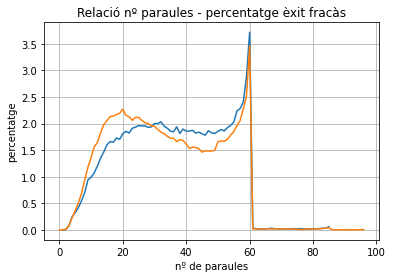

In [27]:
TrueFalsePlot('nameLen', 'nº de paraules', 'percentatge', 'Relació nº paraules - percentatge èxit fracàs')

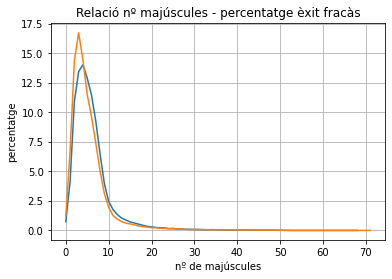

In [28]:
TrueFalsePlot('UpperCaseN', 'nº de majúscules', 'percentatge', 'Relació nº majúscules - percentatge èxit fracàs')

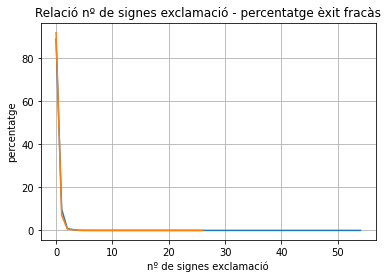

In [29]:
TrueFalsePlot('exclamationN', 'nº de signes exclamació', 'percentatge',  'Relació nº de signes exclamació - percentatge èxit fracàs')

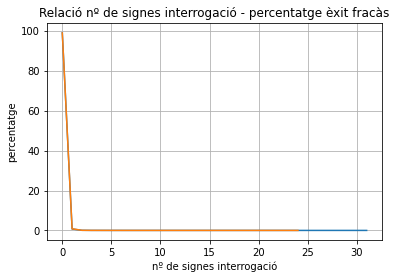

In [30]:
TrueFalsePlot('questionN', 'nº de signes interrogació', 'percentatge', 'Relació nº de signes interrogació - percentatge èxit fracàs')

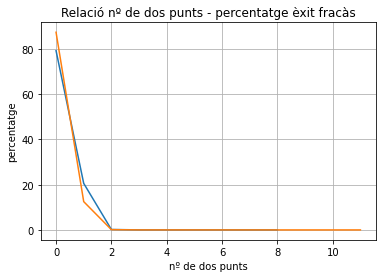

In [31]:
TrueFalsePlot('twopointsN', 'nº de dos punts', 'percentatge', 'Relació nº de dos punts - percentatge èxit fracàs')

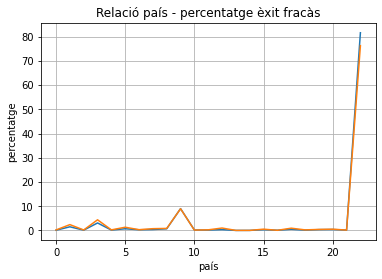

In [32]:
TrueFalsePlot('country', 'país',  'percentatge', 'Relació país - percentatge èxit fracàs')

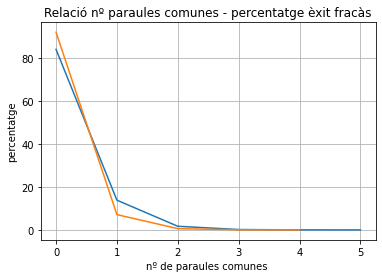

In [33]:
TrueFalsePlot('common', 'nº de paraules comunes ','percentatge', 'Relació nº paraules comunes - percentatge èxit fracàs')

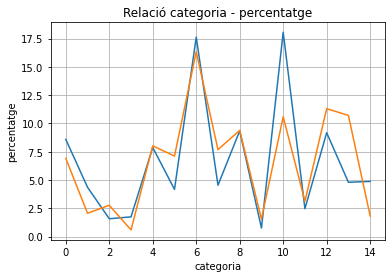

In [34]:
TrueFalsePlot('main_category', 'categoria', 'percentatge', 'Relació categoria - percentatge')

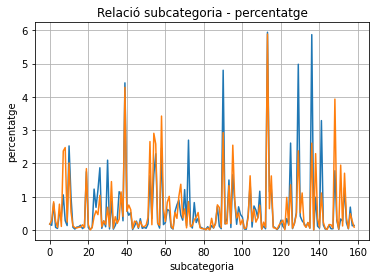

In [35]:
TrueFalsePlot('category', 'subcategoria', 'percentatge', 'Relació subcategoria - percentatge')

Per acabar eliminem del nostre dataFrame les variables que no ens aporten informació a l'hora de classificar entre exit i fracàs dels projectes.

In [36]:
nd = nd.drop(['exclamationN', 'questionN', 'country'], axis=1)

In [37]:
nd.head()

,common,nameLen,twopointsN,UpperCaseN,time,category,main_category,goal,pledged,remain,state
0,1,31,0,4,59,108,12,1533.95,524.0,1009,0
1,0,45,1,12,60,93,6,30000.00,524.0,29476,0
2,0,14,0,2,45,93,6,45000.00,524.0,44476,0
3,0,49,0,7,30,90,10,5000.00,524.0,4476,0
4,0,58,1,7,56,55,6,19500.00,524.0,18976,0


Un cop creat tot el dataFrame, procedim a normalitzar totes les columnes per tal de poder treballar dins d'un mateix rang ([-1, 1])

In [38]:
x = nd.values #returns a numpy array
min_max_scaler = preprocessing.MinMaxScaler((-1, 1))
x_scaled = min_max_scaler.fit_transform(x)
ndf = pd.DataFrame(x_scaled)
print(ndf.shape)
ndf.head()

(370454, 11)


,0,1,2,3,4,5,6,7,8,9,10
0,-0.6,-0.354167,-1.000000,-0.887324,-0.992197,0.367089,0.714286,-0.999982,-1.0,-0.999982,-1.0
1,-1.0,-0.062500,-0.818182,-0.661972,-0.992062,0.177215,-0.142857,-0.999639,-1.0,-0.999639,-1.0
2,-1.0,-0.708333,-1.000000,-0.943662,-0.994080,0.177215,-0.142857,-0.999459,-1.0,-0.999459,-1.0
3,-1.0,0.020833,-1.000000,-0.802817,-0.996098,0.139241,0.428571,-0.999940,-1.0,-0.999940,-1.0
4,-1.0,0.208333,-0.818182,-0.802817,-0.992601,-0.303797,-0.142857,-0.999766,-1.0,-0.999766,-1.0


## Implementació de models de classificació

Seleccionem com a variable que busquem classificar l'estat del projecte

In [39]:
data = ndf.values
X = data[:, :10]
y = data[:, 10]

Separem les dades en conjunt d'entrenament i test. 

També creem un conjunt de X i y mes petit que el normal per poder realitzar operacions que amb el conjunt sencer tindríen un cost computacional inassequible.

In [40]:
x_t, x_v, y_t, y_v = train_test_split(X[:], y[:], test_size=0.33, random_state=42)
x_t5, y_t5 = X[:500], y[:500]

### Xarxes Neuronals

In [43]:
params = dict(activation = ['logistic', 'tanh'], 
              solver = ['lbfgs', 'sdg', 'adam'],
              learning_rate = ['constant', 'invscaling'],
              hidden_layer_sizes = [(20,),(20,20),(20,20,20),(20,20,20,20),
                                    (80,),(80,80),(80,80,80),(80,80,80,80),
                                    (150,),(150,150),(150,150,150),(150,150,150,150)
                                    ]
              )

#W = np.random.randn(150, 150) / np.sqrt(150/2) #inicialitzacio de pesos
model  = MLPClassifier(max_iter = sys.maxsize)
clf = RandomizedSearchCV(model, param_distributions = params, n_iter = 144, n_jobs = -1)
start_time = time.time()
clf.fit(x_t5, y_t5)
print(f"Mejor score obtenida: {clf.best_score_}")
print(f"Parametros usados: {clf.best_params_}")
print(f"Modelo creado: {clf.best_estimator_}")
print("///////////")

print(f"Tiempo de ejecución: {time.time() - start_time:.3f} segundos")

Mejor score obtenida: 0.642
Parametros usados: {'solver': 'adam', 'learning_rate': 'invscaling', 'hidden_layer_sizes': (80,), 'activation': 'tanh'}
Modelo creado: MLPClassifier(activation='tanh', hidden_layer_sizes=(80,),
              learning_rate='invscaling', max_iter=9223372036854775807)
///////////
Tiempo de ejecución: 1546.375 segundos


In [41]:
clf = MLPClassifier(activation='tanh', alpha=0.0001, batch_size='auto', beta_1=0.9,
              beta_2=0.999, early_stopping=False, epsilon=1e-08,
              hidden_layer_sizes=(150,), learning_rate='invscaling',
              learning_rate_init=0.001, max_fun=15000,
              max_iter=9223372036854775807, momentum=0.9, n_iter_no_change=10,
              nesterovs_momentum=True, power_t=0.5, random_state=None,
              shuffle=True, solver='adam', tol=0.0001, validation_fraction=0.1,
              verbose=False, warm_start=False)

clf.fit(x_t, y_t)
clf.score(x_v, y_v)

0.6612760736196319

### Random Forests

In [44]:
params = [     {'n_estimators': [60, 80, 100, 500, 1000, 2000], 'criterion':['gini', 'entropy'],
   'max_depth': [25, 50, 100, None]
  }]
model  = RandomForestClassifier(n_jobs=-1)
clf = RandomizedSearchCV(model, params, random_state=0, scoring='accuracy')
start_time = time.time()
clf.fit(x_t5, y_t5)
print(f"Mejor score obtenida: {clf.best_score_}")
print(f"Parametros usados: {clf.best_params_}")
print(f"Modelo creado: {clf.best_estimator_}")
print("///////////")

print(f"Tiempo de ejecución: {time.time() - start_time:.3f} segundos")

Mejor score obtenida: 0.608
Parametros usados: {'n_estimators': 60, 'max_depth': 50, 'criterion': 'entropy'}
Modelo creado: RandomForestClassifier(criterion='entropy', max_depth=50, n_estimators=60,
                       n_jobs=-1)
///////////
Tiempo de ejecución: 36.033 segundos


In [42]:
clf = RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='entropy', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=500,
                       n_jobs=-1, oob_score=False, random_state=None, verbose=0,
                       warm_start=False)
clf.fit(x_t, y_t)
clf.score(x_v, y_v)

0.6762535787321063

### Ensembles

#### AdaBoost

In [45]:
params = dict(n_estimators = [50, 100, 200, 500, 1000])
model  = AdaBoostClassifier()
clf = RandomizedSearchCV(model, params, random_state=0, scoring='accuracy', n_jobs=-1, n_iter=9)
start_time = time.time()
clf.fit(x_t5, y_t5)
print(f"Mejor score obtenida: {clf.best_score_}")
print(f"Parametros usados: {clf.best_params_}")
print(f"Modelo creado: {clf.best_estimator_}")
print("///////////")

print(f"Tiempo de ejecución: {time.time() - start_time:.3f} segundos")

c:\users\ger-m\appdata\local\programs\python\python39\lib\site-packages\sklearn\model_selection\_search.py:278: UserWarning: The total space of parameters 5 is smaller than n_iter=9. Running 5 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Mejor score obtenida: 0.602
Parametros usados: {'n_estimators': 500}
Modelo creado: AdaBoostClassifier(n_estimators=500)
///////////
Tiempo de ejecución: 7.273 segundos


In [46]:
clf = AdaBoostClassifier(n_estimators=500)
clf.fit(x_t, y_t)
clf.score(x_v, y_v)

0.6950347648261759

#### Bagging

In [ ]:
params = dict(n_estimators = [50, 100, 200, 500, 1000])
model  = BaggingClassifier(n_jobs = -1)
clf = RandomizedSearchCV(model, params, random_state=0, scoring='accuracy', n_jobs=-1, n_iter=9)
start_time = time.time()
clf.fit(x_t5, y_t5)
print(f"Mejor score obtenida: {clf.best_score_}")
print(f"Parametros usados: {clf.best_params_}")
print(f"Modelo creado: {clf.best_estimator_}")
print("///////////")

print(f"Tiempo de ejecución: {time.time() - start_time:.3f} segundos")

/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_search.py:281: UserWarning: The total space of parameters 5 is smaller than n_iter=9. Running 5 iterations. For exhaustive searches, use GridSearchCV.
  % (grid_size, self.n_iter, grid_size), UserWarning)


Mejor score obtenida: 0.608
Parametros usados: {'n_estimators': 1000}
Modelo creado: BaggingClassifier(base_estimator=None, bootstrap=True, bootstrap_features=False,
                  max_features=1.0, max_samples=1.0, n_estimators=1000,
                  n_jobs=-1, oob_score=False, random_state=None, verbose=0,
                  warm_start=False)
///////////
Tiempo de ejecución: 24.674 segundos


In [33]:
clf = BaggingClassifier(base_estimator=None, bootstrap=True, bootstrap_features=False,
                  max_features=1.0, max_samples=1.0, n_estimators=500,
                  n_jobs=-1, oob_score=False, random_state=None, verbose=0,
                  warm_start=False)

clf.fit(x_t, y_t)
clf.score(x_v, y_v)

0.6712310838445807

### Nearest Centroid

In [96]:
clf = NearestCentroid()
clf.fit(x_t, y_t)
clf.score(x_v, y_v)

0.5398445807770961

### Logistic Regression

In [119]:
params = dict(solver = ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'], 
             C = [0.1, 0.5, 1, 10, 50, 100, 500, 1000],
              class_weight = [None, 'Balanced']
             )
model  = LogisticRegression(max_iter=sys.maxsize, multi_class = 'ovr')
clf = RandomizedSearchCV(model, params, random_state=0, scoring='accuracy')
start_time = time.time()
clf.fit(x_t5, y_t5)
print(f"Mejor score obtenida: {clf.best_score_}")
print(f"Parametros usados: {clf.best_params_}")
print(f"Modelo creado: {clf.best_estimator_}")
print("///////////")

print(f"Tiempo de ejecución: {time.time() - start_time:.3f} segundos")

c:\users\ger-m\appdata\local\programs\python\python39\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\users\ger-m\appdata\local\programs\python\python39\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\users\ger-m\appdata\local\programs\python\python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1356, in fit
    self.coef_, self.intercept_, n_iter_ = _fit_liblinear(
  File "c:\users\ger-m\appdata\local\programs\python\python39\lib\site-packages\sklearn\svm\_base.py", line 930, in _fit_liblinear
    class_weight_ = compute_class_weight(class_weight, classes=classes_,
  File "c:\users\ger-m\appdata\local\programs\python\python39\lib\site-packages\sklearn\utils\validation.py", line 72, in i

Mejor score obtenida: 0.642
Parametros usados: {'solver': 'lbfgs', 'class_weight': None, 'C': 1000}
Modelo creado: LogisticRegression(C=1000, max_iter=9223372036854775807, multi_class='ovr')
///////////
Tiempo de ejecución: 0.700 segundos


c:\users\ger-m\appdata\local\programs\python\python39\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\users\ger-m\appdata\local\programs\python\python39\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\users\ger-m\appdata\local\programs\python\python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1407, in fit
    fold_coefs_ = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "c:\users\ger-m\appdata\local\programs\python\python39\lib\site-packages\joblib\parallel.py", line 1048, in __call__
    if self.dispatch_one_batch(iterator):
  File "c:\users\ger-m\appdata\local\programs\python\python39\lib\site-packages\joblib\parallel.py", line 866, in dispatch_one_batch
    self._dispatch

In [105]:
clf = LogisticRegression(C=10, max_iter=9223372036854775807, multi_class='ovr',
                   solver='newton-cg')
clf.fit(x_t, y_t)
clf.score(x_v, y_v)

0.6501104294478528

### Màquines de vectors de suport

In [120]:

params = [     {'C':[0,1,10,100], 'kernel':['linear', 'poly', 'rbf', 'sigmoid'],
                'degree':[2,3,5,10], 'decision_function_shape' : ['ovo', 'ovr']
  }]
model  = svm.SVC()
clf = RandomizedSearchCV(model, params, random_state=0, scoring='accuracy', n_jobs=-1)
start_time = time.time()
clf.fit(x_t5, y_t5)
print(f"Mejor score obtenida: {clf.best_score_}")
print(f"Parametros usados: {clf.best_params_}")
print(f"Modelo creado: {clf.best_estimator_}")
print("///////////")

print(f"Tiempo de ejecución: {time.time() - start_time:.3f} segundos")

Mejor score obtenida: 0.646
Parametros usados: {'kernel': 'linear', 'degree': 5, 'decision_function_shape': 'ovo', 'C': 1}
Modelo creado: SVC(C=1, decision_function_shape='ovo', degree=5, kernel='linear')
///////////
Tiempo de ejecución: 5.463 segundos


In [ ]:
clf = SVC(C=1, decision_function_shape='ovo', degree=5, kernel='linear')
clf.fit(x_t, y_t)
clf.score(x_v, y_v)

### Combinació dels dos models amb millor score

In [118]:
m = LogisticRegression(C=10, max_iter=9223372036854775807, multi_class='ovr',
                   solver='newton-cg')

clf = AdaBoostClassifier(base_estimator = m, n_estimators=500)
clf.fit(x_t, y_t)
clf.score(x_v, y_v)

0.6438936605316974

## Model definitiu

Un cop vists els resultats que obtenim amb els diferents models de classificació, podem arribar a la conclusió de que el millor model que podem utilitzar pel nostre cas és un ensemble AdaBoost que té com a model base un arbre de decisió.

In [42]:
model = AdaBoostClassifier(n_estimators=500)

## CrossValidation

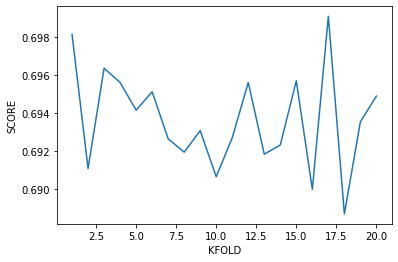

SCORE MAXIMA: 0.6991145664615053 con kfold: 17
SCORE MINIMA: 0.6886945254292193 con kfold: 18


In [67]:
scores = cross_val_score(model, X, y, cv=20)
kfolds = np.arange(1, 21)
plt.plot(kfolds, scores)
plt.xlabel('KFOLD')
plt.ylabel('SCORE')
plt.show()

print(f"SCORE MAXIMA: {scores.max()} con kfold: {kfolds[scores.argmax()]}")
print(f"SCORE MINIMA: {scores.min()} con kfold: {kfolds[scores.argmin()]}")

Com podem veure a la figura superior el nostre model obté una score màxima d'un 0.699% quan es divideixen les dades en 16 conjunts d'entrenament i un de test.

## Analisis mètric

A continuació calcularem la F1 score. Hem decidit fer ús d'aquesta mesura d'anàlisi ja que les dades del nostre conjunt de dades no estàn balancejades, i és probable que obtinguem resultats més fiables utilitzant l'F1 score que no la precisió.

In [47]:
model.fit(x_t, y_t)

a = model.predict(x_v)

print("F1 Score: ", f1_score(y_v, a, average='micro'))

F1 Score:  0.6834519427402863


### Matriu de confusió

A continuació podem veure la matriu de confusió obtinguda a partir del nostre model

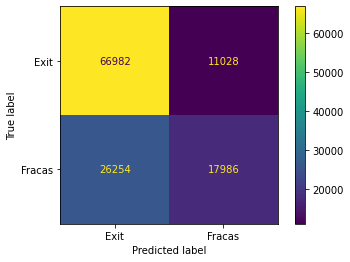

In [71]:
plot_confusion_matrix(model, x_v, y_v, display_labels=['Exit', 'Fracas'])

### Corba PR

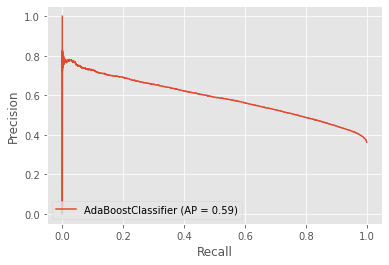

In [44]:
model.fit(x_t, y_t)
disp = plot_precision_recall_curve(model, x_v, y_v)
